# Kaggle: Titanic

Kaggle Problem: [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
        
Objective: predict whether a passenger aboard the Titanic is likely to survive or not survive

Evaluation metric: accuracy of classification 

Modeling methods:
- I fit RidgeClassifier, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, and SVC models with tuned hyperparameters.
- The predictions of the best models were then combined in a voting ensemble.

Results:
- The most important features used by my models to predict whether a passenger on the Titanic survived include: title, gender, and passenger class.
- My voting ensemble achieved an accuracy of 0.80382 on the Kaggle public leaderboard (top 8% score).

# Organization:

1. [The data](#'section_1') 
    1. [Reading in training and test data](#section_1.1)  
    + [Numerical and categorical features](#section_1.2) 

+ [Data cleaning](#section_2)
    1. [Missing data](#section_2.1)   
    + [Outliers](#section_2.2) 

+ [Exploratory data analysis](#section3) 
    1. [Distribution of the target variable](#section_3.1)  
    + [Analysis of features](#section_3.2)     
    + [Correlation analysis](#section_3.3)
        1. [Feature - Target Correlation](#section_3.3.1)  
        + [Feature - Feature Correlation](#section_3.3.2)        
        
+ [Feature engineering](#section4)
    1. [Splitting up 'Cabin': deck, room number, number of rooms](#section_4.1)  
    + [Splitting up 'Ticket': ticket prefix and ticket suffix](#section_4.2)  
    + [Passenger title from 'Name'](#section_4.3)  
    + [Number of traveling companions](#section_4.4)  
    + [Binning 'Age' and 'Fare'](#section_4.5)  
    + [Summary of new features](#section_4.6)      
    
+ [Data pre-processing](#section_5)
    1. [Skewed features and log transforms](#section_5.1)   
    + [sklearn Pipeline for pre-processing](#section_5.2)  
    + [Final prepping of the data before modeling](#section_5.3)  
    
+ [Modeling](#section_6)
    1. [RidgeClassifier](#section_6.1)  
    + [KNeighborsClassifier](#section_6.2)  
    + [RandomForestClassifier](#section_6.3)  
    + [XGBClassifier](#section_6.4)  
    + [SVC](#section_6.5)  

+ [Model ensembling and final results](#section_7)
    1. [Comparing model fits](#section_7.1)  
    + [Voting ensemble](#section_7.2)  
    + [Final predictions from voting ensemble](#section_7.3)  
    + [Feature importances](#section_7.4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. The Data <a id='section_1'></a>
- [1.1 Reading in training and test data](#section_1.1)  
- [1.2 Numerical and categorical features](#section_1.2)   

## 1.1 Reading in training and test data <a id='section_1.1'></a>

In [2]:
# Read in the training and test data sets
X = pd.read_csv('./input/train.csv', index_col='PassengerId')  # training data
X_test = pd.read_csv('./input/test.csv', index_col='PassengerId')  # test data

# Remove any rows from the training set where there is no target
X.dropna(axis=0, subset=['Survived'], inplace=True)

# Separate out the target in the training set
y = X['Survived'] # target

In [3]:
X.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


For convenience, I combine the training and test sets while performing data cleaning, exploratory data analysis, and feature engineering.

In [4]:
# Combining train and test data sets
X_all = pd.concat([X, X_test], axis=0, sort=False)

## 1.2 Numerical and categorical features <a id='section_1.2'></a>

In [5]:
X_all.dtypes

Survived    float64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
# Distinguish between features of different data types

object_cols = [col for col in X.columns if
               X[col].dtype == "object"]

intfloat_cols = [col for col in X.columns if 
                X[col].dtype in ['int64', 'float64'] and col!='Survived']


In [7]:
# Categorical-Nominal features
catnom_cols = list(object_cols)

# Numerical features
num_cols = list(intfloat_cols)

print('Numerical features:', num_cols)
print('Categorical features:', catnom_cols)

Numerical features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


# 2. Data Cleaning <a id='section_2'></a>

- [2.1 Missing data](#section_2.1)   
- [2.2 Outliers](#section_2.2) 

## 2.1 Missing data <a id='section_2.1'></a>

In [8]:
for col in num_cols+catnom_cols:
    if X_all[col].isnull().any():
        print(col, sum(X_all[col].isnull()), np.round(sum(X_all[col].isnull())/len(X_all),2))

Age 263 0.2
Fare 1 0.0
Cabin 1014 0.77
Embarked 2 0.0


** Missing values: 'Embarked' and 'Fare' ** 

'Embarked' and 'Fare' are only missing two values and one value respectively. 'Embarked' is a categorical variable so I'll impute the missing data with the most frequent value for this feature. For 'Fare', a continuous numerical variable, I'll impute with the median.

In [9]:
from sklearn.impute import SimpleImputer

X_all['Embarked'] = SimpleImputer(strategy='most_frequent').fit_transform(X_all[['Embarked']]).ravel()
X_all['Fare'] = SimpleImputer(strategy='median').fit_transform(X_all[['Fare']]).ravel()

** Missing values: 'Cabin' **

'Cabin' is a categorical feature which consists of 77% missing data. Since there is such a signigicant amount of missing values, I'll replace np.nan with 'None' so that missing data is treated as its own category during encoding.

In [10]:
X_all['Cabin'] = X_all['Cabin'].fillna(value='None')

** Missing values: 'Age' **  

The 'Age' feature consists of 20% missing data. I'll impute these missing values through KNN imputation. I determine the number of neighbors for the imputation by iterating over a range of possible n_neighbors values and choosing the value that produces the highest accuracy score using a baseline model of Ridge classification.

In [11]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV

# function to quickly fit a simple baseline model
def get_score(X,y):
    model = RidgeClassifierCV()
    model.fit(X, y)
    return model.score(X, y)

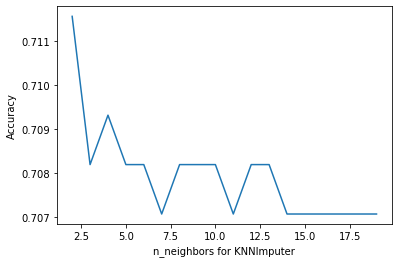

In [12]:
from sklearn.impute import KNNImputer

score_list = []
n_neighbors_list = np.arange(2,20,1)
for n_neighbors in n_neighbors_list:
    X_temp = X_all.loc[:X.shape[0], num_cols].copy()
    X_temp[num_cols] = KNNImputer(n_neighbors=n_neighbors).fit_transform(X_temp)
    score_list.append(get_score(X_temp, y))

plt.plot(n_neighbors_list, score_list)
plt.xlabel('n_neighbors for KNNImputer')
plt.ylabel('Accuracy');   

KNN Imputation with two neighbors results in the highest accuracy score using a baseline model.

In [13]:
X_all[num_cols] = KNNImputer(n_neighbors=2).fit_transform(X_all[num_cols])

## 2.2 Outliers <a id='section_2.2'></a>
The distribution of 'Fare' contains visible outliers for 'Fare'>500.

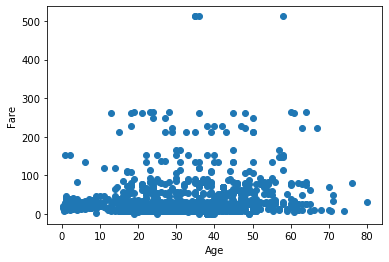

In [14]:
plt.scatter(X_all['Age'], X_all['Fare'])
plt.xlabel('Age')
plt.ylabel('Fare');

In [15]:
X_all[X_all['Fare']>500]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1.0,1.0,"Ward, Miss. Anna",female,35.0,0.0,0.0,PC 17755,512.3292,None,C
680,1.0,1.0,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0.0,1.0,PC 17755,512.3292,B51 B53 B55,C
738,1.0,1.0,"Lesurer, Mr. Gustave J",male,35.0,0.0,0.0,PC 17755,512.3292,B101,C
1235,NaN,1.0,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0.0,1.0,PC 17755,512.3292,B51 B53 B55,C


Four passengers have a recorded 'Fare'>500, and all have the same ticket number of "PC 17755". 

Researching further, Lesurer, Mr. Gustave J and Ward, Miss. Anna were both employed by the Cardeza family and are on the same ticket as  Cardeza, Mr. Thomas Drake Martinez and Cardeza, Mrs. James Warburton Martinez.
https://www.encyclopedia-titanica.org/titanic-survivor/thomas-cardeza.html

Thus the fare of this ticket seems to account for the price of four people to travel. 

I tested two options to treat these outlying points:
1. removing 'Fare'>500 passengers
2. scaling the 'Fare'>500 data points by four, since I have confirmed it represents the combined fare for four passengers

Both treatment options slightly reduced the accuracy of a baseline RidgeClassifier model. Since modeling appears to be mostly unaffected by these points, I'll just leave these outliers as they are in the training set.

# 3. Exploratory data analysis <a id='section_3'></a>

[3.1 Distribution of the target variable](#section_3.1)  

[3.2 Analysis of features](#section_3.2)     

[3.3 Correlation analysis](#section_3.3)
- [3.3.1 Feature - Target Correlation](#section_3.3.1)  
- [3.3.2 Feature - Feature Correlation](#section_3.3.2)  


## 3.1 Distribution of the target variable  <a id='section_3.1'></a>

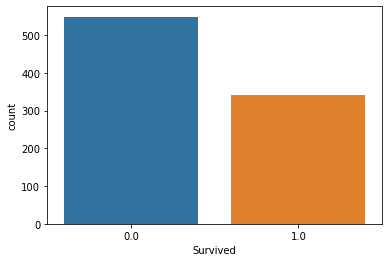

In [16]:
sns.countplot(x="Survived", hue=None, data=X_all);

The majority of passengers on the Titanic did not survive. In the training data set, 38% of passengers survived and 62% of passengers did not.

## 3.2 EDA: Analysis of features <a id='section_3.2'></a>

### EDA: 'Pclass'

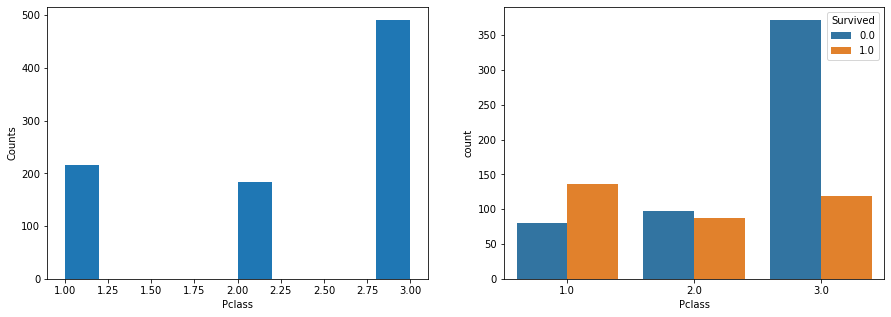

In [17]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X['Pclass'])
plt.xlabel('Pclass')
plt.ylabel('Counts')

plt.subplot(1,2,2)
sns.countplot(x="Pclass", hue="Survived", data=X_all);

In [18]:
pd.crosstab(X_all['Pclass'], X_all['Survived'], normalize='index')

Survived,0.0,1.0
Pclass,,
1.0,0.370370,0.629630
2.0,0.527174,0.472826
3.0,0.757637,0.242363


Most passengers (54%) are in the third passenger class. First and second class account for 25% and 21% of the passengers respectively.

In terms of survivability, only first class has a greater probability of surviving (63%) than not surviving (37%). Second class has near equal probability for surviving (47%) or not surviving (52%). Third class has the lowest survival probability (24%).

### EDA: 'Sex '

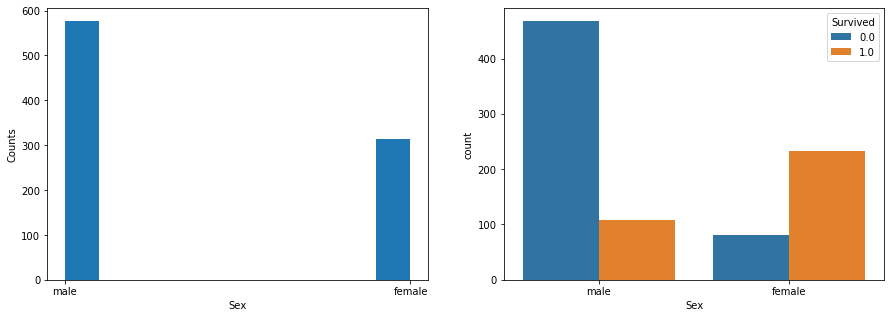

In [19]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X['Sex'])
plt.xlabel('Sex')
plt.ylabel('Counts')

plt.subplot(1,2,2)
sns.countplot(x="Sex", hue="Survived", data=X_all);

In [20]:
pd.crosstab(X_all['Sex'], X_all['Survived'], normalize='index')

Survived,0.0,1.0
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


The gender composition of the training data consists of 36% female, 64% male. 

There is a substantial gender disparity in survival rates: 74% of female passengers survived, while in comparison only 19% of male passengers survived.

### EDA: 'Age'

/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


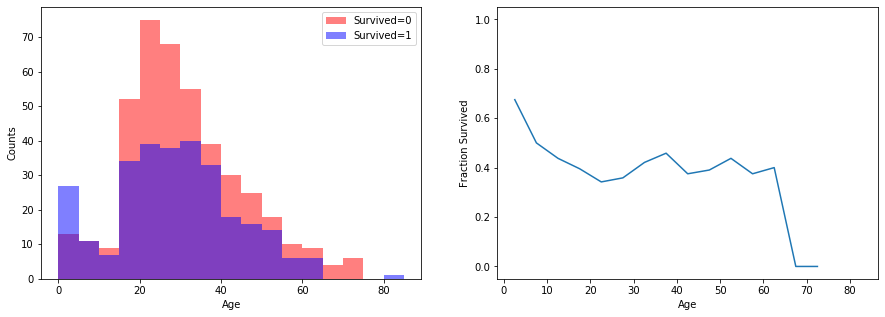

In [21]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X['Age'][X['Survived']==0], bins=np.arange(0,90,5), alpha=0.5, color='r', label='Survived=0')
plt.hist(X['Age'][X['Survived']==1], bins=np.arange(0,90,5), alpha=0.5, color='b', label='Survived=1')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.legend()


plt.subplot(1,2,2) 
counts_total, bin_edges = np.histogram(X['Age'], bins = np.arange(0,90,5))
counts_survived, bin_edges = np.histogram(X['Age'][X['Survived']==1], bins = np.arange(0,90,5))
plt.plot(bin_edges[:-1]+2.5, counts_survived/counts_total)
plt.xlabel('Age')
plt.ylabel('Fraction Survived');

The probability of survival changes with age. Children have the highest survival rate, and elderly passengers the lowest.

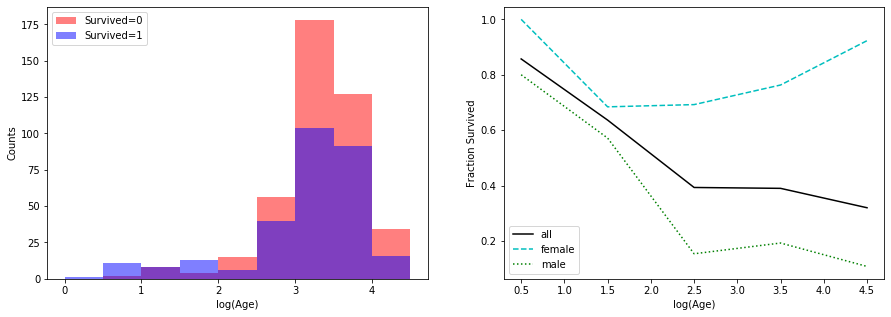

In [22]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(np.log1p(X['Age'][X['Survived']==0]), bins=np.arange(0,5,0.5), alpha=0.5, color='r', label='Survived=0')
plt.hist(np.log1p(X['Age'][X['Survived']==1]), bins=np.arange(0,5,0.5), alpha=0.5, color='b', label='Survived=1')
plt.xlabel('log(Age)')
plt.ylabel('Counts')
plt.legend()


plt.subplot(1,2,2) 

counts_total, bin_edges = np.histogram(np.log1p(X['Age']), bins = np.arange(0,5.5,1))
counts_survived, bin_edges = np.histogram(np.log1p(X['Age'][X['Survived']==1]), bins = np.arange(0,5.5,1))
plt.plot(bin_edges[:-1]+0.5, counts_survived/counts_total, c='k',label='all')

counts_female, bin_edges = np.histogram(np.log1p(X['Age'][X['Sex']=='female']), bins = np.arange(0,5.5,1))
counts_survived_female, bin_edges = np.histogram(np.log1p(X['Age'][X['Survived']==1][X['Sex']=='female']), bins = np.arange(0,5.5,1))
plt.plot(bin_edges[:-1]+0.5, counts_survived_female/counts_female, c='c', linestyle='--',label='female')

counts_male, bin_edges = np.histogram(np.log1p(X['Age'][X['Sex']=='male']), bins = np.arange(0,5.5,1))
counts_survived_male, bin_edges = np.histogram(np.log1p(X['Age'][X['Survived']==1][X['Sex']=='male']), bins = np.arange(0,5.5,1))
plt.plot(bin_edges[:-1]+0.5, counts_survived_male/counts_male, c='g',linestyle=':',label='male')

plt.legend()
plt.xlabel('log(Age)')
plt.ylabel('Fraction Survived');

Interesting trends in the age - survivability relation are apparent when distinguishing by gender. 

The average age-survivability trend is that the survival fraction declines with age. Because there are more male passengers than female passengers, the average age-survivability pattern follows from the male age-survivability trend.

However, when examining the age-survivability pattern for female passengers, we see that both young children and elderly female passengers have a high survival fraction, while elderly male passengergers have the lowest survival fraction.

### EDA: 'Fare'

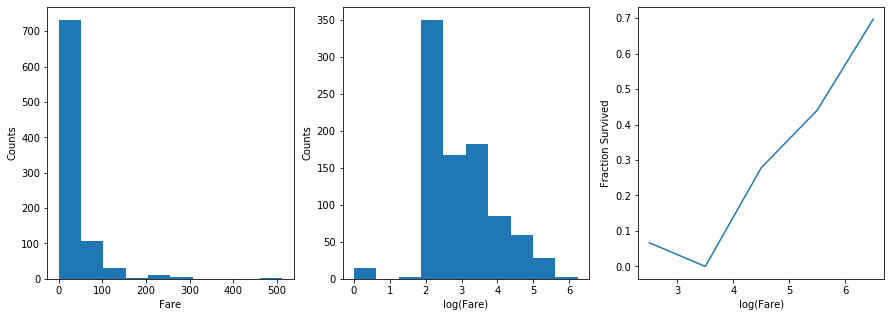

In [23]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X['Fare'])
plt.xlabel('Fare')
plt.ylabel('Counts')

plt.subplot(1,3,2)
plt.hist(np.log1p(X['Fare']))
plt.xlabel('log(Fare)')
plt.ylabel('Counts')

plt.subplot(1,3,3)
counts_total, bin_edges = np.histogram(np.log1p(X['Fare']), bins = np.arange(0,6,1))
counts_survived, bin_edges = np.histogram(np.log1p(X['Fare'][X['Survived']==1]), bins = np.arange(0,6,1))
plt.plot(bin_edges[:-1]+2.5, counts_survived/counts_total)
plt.xlabel('log(Fare)')
plt.ylabel('Fraction Survived');

Passengers who paid a higher fare have a greater probability of surviving. This seems to match well with previous plots which showed first class passengers have the greatest probability of surviving compared to other passenger classes. 

### EDA: 'SibSp' and 'Parch'
SibSp = # of siblings / spouses aboard the Titanic  
Parch = # of parents / children aboard the Titanic

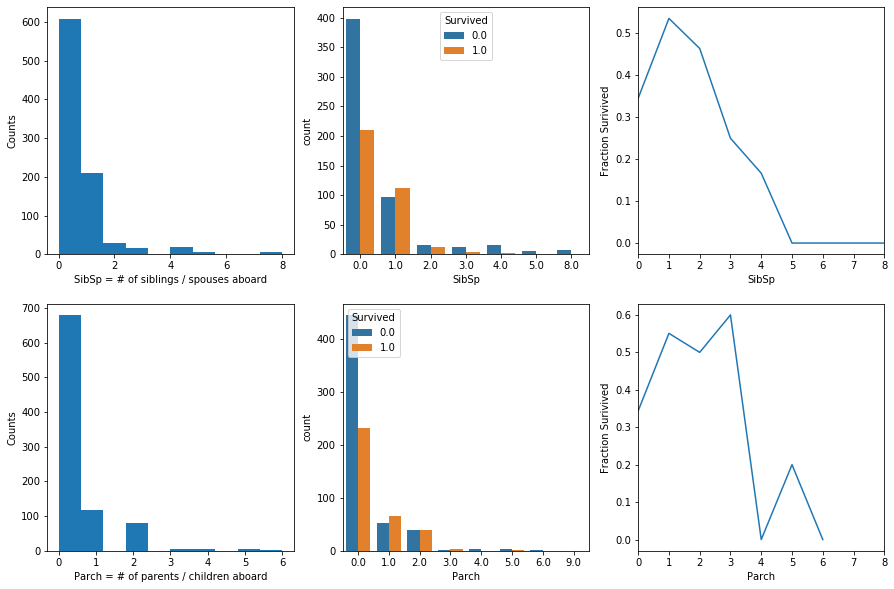

In [24]:
fig = plt.figure(figsize=(15, 10)) # (width,height)

plt.subplot(2,3,1)
plt.hist(X['SibSp'])
plt.xlabel('SibSp = # of siblings / spouses aboard')
plt.ylabel('Counts')

plt.subplot(2,3,2) 
sns.countplot(x="SibSp", hue="Survived", data=X_all)

plt.subplot(2,3,3)
SibSp_grouped = X.groupby(['SibSp']).mean()['Survived']
plt.plot(SibSp_grouped.index, SibSp_grouped)
plt.xlim(0,8)
plt.xlabel('SibSp')
plt.ylabel('Fraction Surivived')

plt.subplot(2,3,4) 
plt.hist(X['Parch'])
plt.xlabel('Parch = # of parents / children aboard')
plt.ylabel('Counts')

plt.subplot(2,3,5) 
sns.countplot(x="Parch", hue="Survived", data=X_all)

plt.subplot(2,3,6)
Parch_grouped = X.groupby(['Parch']).mean()['Survived']
plt.plot(Parch_grouped.index, Parch_grouped)
plt.xlim(0,8)
plt.xlabel('Parch')
plt.ylabel('Fraction Surivived');

'Parch' and 'SibSp' show similar trends with survivability. The highest probability of survival occurs for those passengers traveling with 1-3 companions. The second best rate of survival occurs for those traveling by themselves. The worst survival fraction occurs for those traveling with 4+ companions.

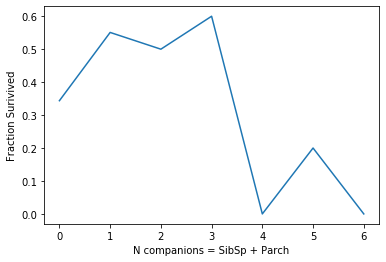

In [25]:
X_temp = X.copy()
X_temp['N_companions'] = X['Parch']+X['SibSp']
companions_grouped = X_temp.groupby(['N_companions']).mean()['Survived']
plt.plot(Parch_grouped.index, Parch_grouped)
plt.xlabel('N companions = SibSp + Parch')
plt.ylabel('Fraction Surivived');

Combining 'SibSp' and 'Parch' creates the total number of traveling companions identified as siblings, spouses, parents, or children of the passenger. In general we see that 1-3 companions is ideal with 50-60% probability of survival, traveling alone decreases survivability to about ~35%, and traveling with 4 or more companions has the worst survivability of 0-20%. 

### EDA: 'Embarked'
C = Cherbourg, Q = Queenstown, S = Southampton

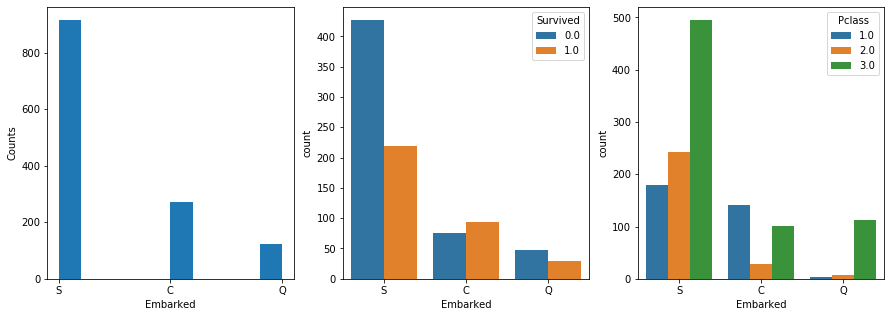

In [26]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1) 
plt.hist(X_all['Embarked'][X_all['Embarked'].notnull()])
plt.xlabel('Embarked')
plt.ylabel('Counts')

plt.subplot(1,3,2) 
sns.countplot(x="Embarked", hue="Survived", data=X_all)

plt.subplot(1,3,3)
sns.countplot(x="Embarked", hue="Pclass", data=X_all);

In [27]:
pd.crosstab(X_all['Embarked'], X_all['Survived'], normalize='index')

Survived,0.0,1.0
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.660991,0.339009


There is likely no inherent reason a port itself has an influence on survival probability. However, each port has different demographics in terms of passenger class, age, and gender which do have an influence on survival probability.

More passengers depart from Southampton than the other two ports combined, and this port is associated with a survival fraction of 0.34, similar to the overall survival fraction.

Cherbourg has nearly equal probabilities of surviving or not surviving, and passengers departing from this port are classified as mostly first or third class passengers, with few second class passengers.

Queenstown passengers are mostly identified as third class, and this port is associated with a survival fraction of 0.39.

## 3.3 EDA: Correlation analysis <a id='section_3.3'></a>

- [3.3.1 Feature - Target Correlation](#section_3.3.1)  
- [3.3.2 Feature - Feature Correlation](#section_3.3.2)  

### 3.3.1 Feature  - Target Correlation <a id='section_3.3.1'></a>

In [28]:
# Calculate Pearson correlation between the target and numerical features
corr = X_all[num_cols].corrwith(y)
print(corr.sort_values(ascending=False))

# List of features most strongly correlated with target
corr_top = list(np.abs(corr).sort_values(ascending=False).keys())

Fare      0.257307
Parch     0.081629
SibSp    -0.035322
Age      -0.074546
Pclass   -0.338481
dtype: float64


The features most strongly correlated with the target variable 'Survived' are: 'Pclass' (r=-0.34) and 'Fare' (r=0.26).

First class passengers have the greatest probability of surviving, while third class passengers have the lowest. Passengers who paid a higher fare have a greater probability of surviving compared to passengers who paid a lower fare. Furthermore, the corollary -  first class passengers are associated with paying a higher fare, and third class passengers are associated with paying a lower fare - is indicated by the strong correlation between 'Pclass' and 'Fare' (r=-0.558).

### 3.3.2 Feature  - Feature Correlation <a id='section_3.3.2'></a>

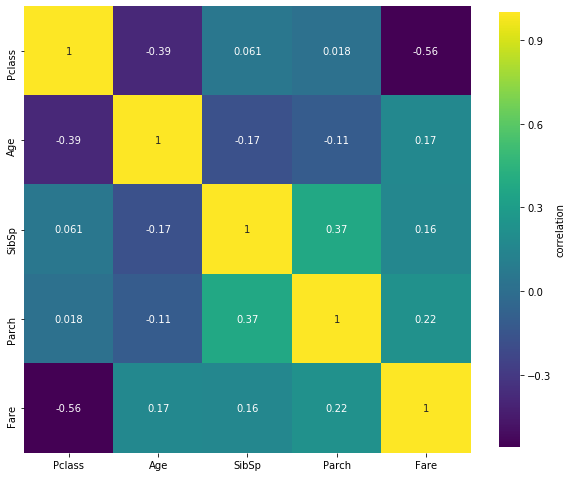

In [29]:
# Plot correlation map of features

fig = plt.figure(figsize=(10, 10)) # (width,height)
corr_map = X_all[num_cols].corr()
sns.heatmap(corr_map, cmap='viridis', square=True, 
            annot=True, annot_kws={'size': 10}, cbar_kws={'shrink': 0.8,'label': 'correlation'});

In [30]:
# Identify collinearity in features

corr = X_all[num_cols].corr()
df_corr = pd.DataFrame(columns=['feat1','feat2','corr(feat1,feat2)'])
corr_high = corr[(np.abs(corr)<1)&(np.abs(corr)>0.)]
for col in corr_high.columns: 
    if corr_high[col].count()>0:
        dat = corr_high[col]
        for ii in range(0,len(dat[dat.notnull()].keys())):
            df_corr = df_corr.append({'feat1': col,
                                      'feat2': dat[dat.notnull()].keys()[ii], 
                                      'corr(feat1,feat2)': dat[dat.notnull()].values[ii]}, 
                                      ignore_index=True)
cols_collinear = df_corr['feat1'].unique()
df_corr = df_corr.sort_values(by='corr(feat1,feat2)', ascending=False).drop_duplicates(subset='corr(feat1,feat2)', keep='first')

In [31]:
df_corr

,feat1,feat2,"corr(feat1,feat2)"
10,SibSp,Parch,0.373587
15,Parch,Fare,0.221635
7,Age,Fare,0.169310
11,SibSp,Fare,0.160349
8,SibSp,Pclass,0.060832
12,Parch,Pclass,0.018322
6,Age,Parch,-0.113767
5,Age,SibSp,-0.169631
4,Age,Pclass,-0.385134
3,Pclass,Fare,-0.558683


The greatest feature-feature correlation is between 'Pclass' and 'Fare' with a -0.56 correlation indicating that greater fares were associated with first class passengers and lesser fares were associated with third class passengers. 

A somewhat weaker correlation (r=-0.39) exists between 'Pclass' and 'Age'. First class passengers have a median age of 40 y, second class passengers have a median age of 30 y, and third class passengers have a median of 27 y.

# 4. Feature Engineering <a id='section_4'></a>
[4.1 Splitting up 'Cabin': deck, room number, number of rooms](#section_4.1)  
[4.2 Splitting up 'Ticket': ticket prefix and ticket suffix](#section_4.2)  
[4.3 Passenger title from 'Name'](#section_4.3)  
[4.4 Number of traveling companions](#section_4.4)  
[4.5 Binning 'Age' and 'Fare'](#section_4.5)  
[4.6 Summary of new features](#section_4.6)  

## 4.1 Splitting up 'Cabin': deck, room number, number of rooms <a id='section_4.1'></a>

In [32]:
deck = X_all['Cabin'].copy()
room_number = X_all['Cabin'].copy()
N_cabin = pd.Series(np.zeros(len(X_all)), name='NCabin', index=X_all.index)
cabin_bool = pd.Series(np.zeros(len(X_all)), name='CabinBool', index=X_all.index)
for index in X_all[X_all['Cabin']!='None'].index:
    
    # Some passengers are listed with more than one cabin
    cabins = X_all.loc[index,'Cabin'].split(' ')
    
    # Record number of cabins
    N_cabin[index] = len(cabins)
    cabin_bool[index] = 1
    
    # Assign deck and room number based on first entry in cabins
    deck.loc[index] = cabins[0][0]
    if len(cabins[0])>1:
        room_number[index] = int(cabins[0][1:])
    else:
        room_number[index] = None

room_number = room_number.replace(to_replace='None', value=-1)
X_all['Deck'] = deck
X_all['NCabin'] = N_cabin
X_all['CabinBool'] = cabin_bool

# Instead of adding RoomNumber, add instead CabinBool
#X_all['RoomNumber'] = RoomNumber.apply(pd.to_numeric)

# Don't need 'Cabin' anymore
X_all = X_all.drop('Cabin', axis=1) 

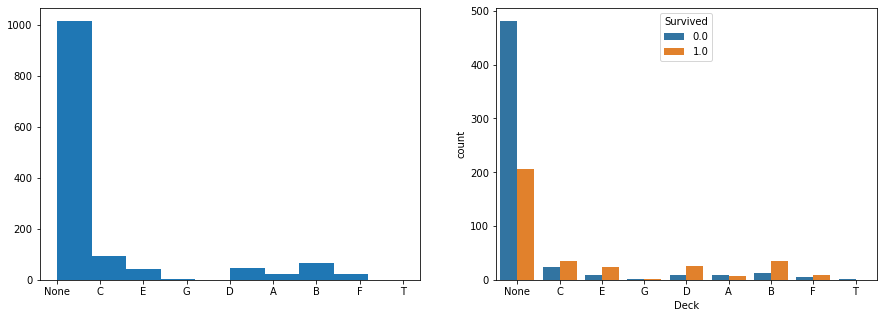

In [33]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X_all['Deck'][X_all['Deck'].notnull()])

plt.subplot(1,2,2) 
sns.countplot(x="Deck", hue="Survived", data=X_all);

The relation of 'Deck' to survival probability may be related to the staggered flooding times of the decks or varying distances to the lifeboats from different decks. 

In [34]:
pd.crosstab(X_all['Deck'], X_all['Survived'], normalize='index')

Survived,0.0,1.0
Deck,,
A,0.533333,0.466667
B,0.255319,0.744681
C,0.406780,0.593220
D,0.242424,0.757576
E,0.250000,0.750000
F,0.384615,0.615385
G,0.500000,0.500000
None,0.700146,0.299854
T,1.000000,0.000000


## 4.2 Splitting up 'Ticket': ticket prefix and ticket suffix <a id='section_4.2'></a>
'Ticket' values can come in two varieties: 
- a string of numbers (e.g., '36568') 
- a combination of a prefix containing letters (or letters and numbers) followed by a suffix consisting of just numbers (e.g., 'A/4 48871')

In [35]:
ticket_prefix = []
ticket_suffix = []
ticket_prefix_bool = [] # indicates if a ticket_prefix was recorded
for index in X_all.index:
    ticket = X_all.loc[index,'Ticket']
    
    # Both prefix and suffix in ticket string
    if (' ' in ticket):
        ws_index = ticket.rfind(' ') 
        ticket_prefix.append(ticket[:ws_index])
        ticket_suffix.append(int(ticket[ws_index+1:]))
        ticket_prefix_bool.append(1)             
    
    # Just numerical suffix in ticket string
    else:
        ticket_prefix.append('None')
        ticket_prefix_bool.append(0)
        try:
            ticket_suffix.append(int(ticket))
        except:
            ticket_suffix.append(None)

X_all['TicketPrefix'] = ticket_prefix
X_all['TicketPrefixBool'] = ticket_prefix_bool

# No real benefit to adding the ticket suffix
#X_all['Ticket_suffix'] = ticket_suffix

# Don't need to keep original 'Ticket' column
X_all = X_all.drop('Ticket', axis=1)

In [36]:
# Standardizing the spelling of the ticket prefixes
for index in X_all.loc[X_all[X_all['TicketPrefix']!='None'].index,'TicketPrefix'].index:
    X_all.loc[index,'TicketPrefix'] = X_all.loc[index,'TicketPrefix'].replace('.', '').replace('/', '').replace(' ', '')

In [37]:
# Combining a few similar ticket prefixes by hand
X_all['TicketPrefix'] = X_all['TicketPrefix'].replace('SCParis', 'SCPARIS')
X_all['TicketPrefix'] = X_all['TicketPrefix'].replace('SOTONO2', 'STONO2')
X_all['TicketPrefix'] = X_all['TicketPrefix'].replace('STONOQ', 'SOTONOQ')
X_all['TicketPrefix'] = X_all['TicketPrefix'].replace('CASOTON', 'CA')


# If less than four instances of a ticket prefix occur, replace with 'other'
val_counts = X_all['TicketPrefix'].value_counts()
for prefix in val_counts.keys()[val_counts.values<=4]:
    X_all.loc[X_all['TicketPrefix']==prefix, 'TicketPrefix'] = 'other'

In [38]:
X_all['TicketPrefix'].value_counts()

None       961
PC          92
CA          69
other       34
A5          28
SOTONOQ     25
STONO2      24
SCPARIS     19
WC          15
A4          10
FCC          9
C            8
SOC          8
SOPP         7
Name: TicketPrefix, dtype: int64

## 4.3 Passenger title from 'Name' <a id='section_4.3'></a>

In [39]:
title = []
for index in X_all.index:
    
    name = X_all.loc[index,'Name'].split()
    
    if 'Mr.' in name:
        title.append('Mr.')
    elif 'Master.' in name:
        title.append('Master.') 
        
    elif 'Miss.' in name:
        title.append('Miss.')
    elif ('Ms.' in name) or ('Mlle.' in name):
        title.append('Ms.')
    elif 'Mrs.' in name:
        title.append('Mrs.')
    elif 'Mme.' in name:
        title.append('Mme.')
        

    elif 'Rev.' in name:
        title.append('Rev.')
    elif 'Dr.' in name:
        title.append('Dr.')
    elif ('Major.' in name) or ('Capt.' in name) or ('Col.' in name):
        title.append('Military')
    elif ('Don.' in name) or ('Sir.' in name)  or ('Jonkheer.' in name) \
        or ('Lady.' in name) or ('Countess.' in name) or ('Dona.' in name):
        title.append('Nobility')
        
    else:
        title.append(None)

X_all['Title'] = title

# Don't need 'Name' anymore
X_all = X_all.drop('Name', axis=1)

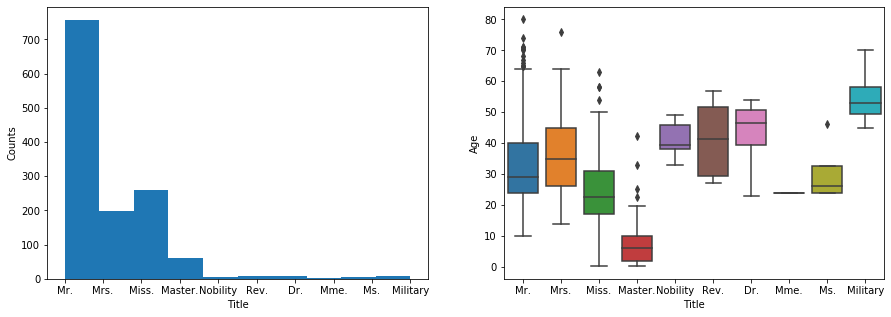

In [40]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X_all['Title'][X_all['Title'].notnull()])
plt.xlabel('Title')
plt.ylabel('Counts')

plt.subplot(1,2,2)
sns.boxplot(x="Title", y="Age", hue=None, data=X_all);

In [41]:
# Combining some low frequency titles
X_all.loc[X_all['Title']=='Ms.', 'Title'] = 'Miss.'
X_all.loc[X_all['Title']=='Mme.', 'Title'] = 'Mrs.'

X_all.loc[X_all['Title']=='Rev.', 'Title'] = 'Profession'
X_all.loc[X_all['Title']=='Dr.', 'Title'] = 'Profession'
X_all.loc[X_all['Title']=='Military', 'Title'] = 'Profession'

In [42]:
pd.crosstab(X_all['Title'], X_all['Survived'], normalize='index')

Survived,0.0,1.0
Title,,
Master.,0.425000,0.575000
Miss.,0.297297,0.702703
Mr.,0.843327,0.156673
Mrs.,0.206349,0.793651
Nobility,0.400000,0.600000
Profession,0.722222,0.277778


## 4.4 Number of traveling companions <a id='section_4.4'></a>
How many siblings, spouses, parents, or children are traveling with a given passenger?

In [43]:
N_companions = [] # how many people is the passenger traveling with?
companions = [] # boolean, yes for traveling companions, no for none

for index in X_all.index:
    parch = X_all.loc[index,'Parch']
    sibsp = X_all.loc[index,'SibSp']
    
    N_companions.append(parch+sibsp)
    
    if parch+sibsp==0:
        companions.append(0)
    else:
        companions.append(1)

X_all['NCompanions'] = N_companions
X_all['CompanionsBool'] = companions

## 4.5 Binning 'Age' and 'Fare' <a id='section_4.5'></a>

### Binning: 'Age'

Age is related to survivability - children have the highest survival fraction while elderly passengers have, on average, the lowest. I'll create age categories based how the fraction of survived passengers changes with age.

/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


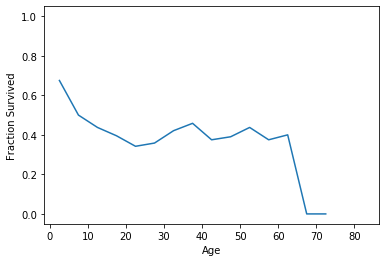

In [44]:
plt.subplot(1,1,1) 
counts_total, bin_edges = np.histogram(X['Age'], bins = np.arange(0,90,5))
counts_survived, bin_edges = np.histogram(X['Age'][X['Survived']==1], bins = np.arange(0,90,5))
plt.plot(bin_edges[:-1]+2.5, counts_survived/counts_total)
plt.xlabel('Age')
plt.ylabel('Fraction Survived');

Based on this plot, it seems reasonable to implement age categories as: 
(0, 5], (5, 10], (10, 22], (22, 38], (38, 68], (68, 90]

In [45]:
# Binning Age based on relation between age and survivability

X_all['AgeBin'] = pd.cut(X_all['Age'],bins=[0,5,10,22,38,68,90]).values

rank = 1
for age_bin in pd.unique(X_all['AgeBin'].sort_values()):
    X_all['AgeBin'] = X_all['AgeBin'].replace(to_replace=age_bin, value=rank)
    rank+=1

### Binning: 'Fare'
Higher fares are associated with a greater probability of survival. This relation is quite clear when looking at the relation between log('Fare') and fraction survived, so I'll create bins of 'Fare' in log space.

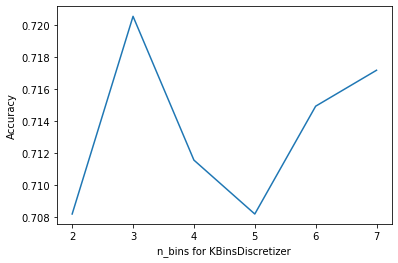

In [46]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins_list = [2,3,4,5,6,7]
score_list = []
for n_bin in n_bins_list:
    X_temp = X_all.loc[X_all['Survived'].notnull(),num_cols].copy()
    est = KBinsDiscretizer(n_bins=n_bin, encode='ordinal', strategy='uniform')
    X_temp['FareBin'] = est.fit_transform(np.log1p(X_temp[['Fare']])).ravel()
    
    score_list.append(get_score(X_temp,y))
    

plt.plot(n_bins_list, score_list)
plt.xlabel('n_bins for KBinsDiscretizer')
plt.ylabel('Accuracy');

The best accuracy is achieved when dividing log('Fare') into 3 bins of uniform widths.

In [47]:
est = KBinsDiscretizer(n_bins=n_bin, encode='ordinal', strategy='uniform')
X_all['FareBin'] = est.fit_transform(np.log1p(X_all[['Fare']])).ravel()

## 4.6 Summary of new created features <a id='section_4.6'></a>

In [48]:
# New features list
new_cols = list(set(X_all.columns)-set(X.columns))


# New nominal features - need to be encoded like nominal data
catnom_cols_new = [col for col in new_cols if
                   X_all[col].dtype == "object"]

# New numerical features
num_cols_new = [col for col in new_cols if 
                X_all[col].dtype in ['int64', 'float64']]


In [49]:
new_cols

['Title',
 'Deck',
 'NCabin',
 'TicketPrefix',
 'FareBin',
 'NCompanions',
 'CabinBool',
 'CompanionsBool',
 'AgeBin',
 'TicketPrefixBool']

In [50]:
num_cols_new

['NCabin',
 'FareBin',
 'NCompanions',
 'CabinBool',
 'CompanionsBool',
 'AgeBin',
 'TicketPrefixBool']

In [51]:
# Separate train and test data
X_new = X_all[:X.shape[0]].drop('Survived', axis=1)
X_test_new = X_all[X.shape[0]:].drop('Survived', axis=1)
print('Check train and test index labels match originals:', set(X_new.index==X.index), set(X_test_new.index==X_test.index))

Check train and test index labels match originals: {True} {True}


# 5. Data pre-processing <a id='section_5'></a>
 
[5.1 Skewed features and log transforms](#section_5.1)   
[5.2 sklearn Pipeline for pre-processing](#section_5.2)  
[5.3 Final prepping of the data before modeling](#section_5.3)  

## 5.1 Skewed features and log transforms <a id='section_5.1'></a>
Determine the skew of numeric features and assess if performing a log(1+x) transform is effective at reducing skew.

In [52]:
from scipy.stats import skew
from scipy.stats import skewtest
from scipy.stats import boxcox
from scipy.stats import pearsonr
from scipy.stats import yeojohnson

df = pd.DataFrame(columns=['features', 'skewtest_pval', 'col_skew', 'log1p_skew', 'yj_skew', 
                           'pdiff(col_skew,log1p_skew)', 'change'])
for i, col in enumerate(num_cols+num_cols_new):

    transform = 'log_transform' #yj_transform, log_transform
    
    pval = skewtest(X_all[col])[1]
    col_skew = X_all[col].skew()
    
    lp_skew = np.log1p(X_all[col]).skew() # log(1+x) transform
    
    
    pdiff = np.abs(np.abs(col_skew)-np.abs(lp_skew))/np.abs(col_skew) # percent difference
    
    yj_skew = skew(yeojohnson(X_all[col])[0]) # yeo-johnson transform
    pdiff2 =np.abs(np.abs(col_skew)-np.abs(yj_skew))/np.abs(col_skew)
    
    r2before = np.round(X_all[col].corr(y),decimals=2)
    
    # is a transform of the column effective at reducing skew?
    change=0
    if transform == 'log_transform':
        r2after = np.round(np.log1p(X_all[col]).corr(y), decimals=2)
        if (pval<0.05) and (pdiff>0.1) and (np.abs(lp_skew)<np.abs(col_skew)) \
            and (np.abs(r2after)>=np.abs(r2before)): # for log(1+x) transform
            change=1
        
    if transform == 'yj_transform':
        if (pval<0.05) and (pdiff2>0.1) and (np.abs(yj_skew)<np.abs(col_skew)): # yeo-johnson transform
            change=1
               
    df.loc[i]=[col, pval, col_skew, lp_skew, yj_skew, pdiff, change]

df = df.sort_values(by='col_skew', ascending=False)

skewed_cols = list(set(df[df['change']==1]['features']))

df

,features,skewtest_pval,col_skew,log1p_skew,yj_skew,"pdiff(col_skew,log1p_skew)",change
4,Fare,9.927930e-185,4.369510,0.542617,-0.056882,8.758174e-01,1
2,SibSp,6.953736e-166,3.844220,1.636821,0.795656,5.742125e-01,0
3,Parch,2.663001e-159,3.669078,1.789762,1.255973,5.122039e-01,1
7,NCompanions,2.293659e-126,2.853078,1.184768,0.536436,5.847406e-01,1
5,NCabin,7.085303e-121,2.726190,1.713223,1.314939,3.715688e-01,1
8,CabinBool,1.540364e-52,1.316125,1.316125,1.314616,3.374219e-16,0
11,TicketPrefixBool,3.466481e-39,1.061224,1.061224,1.060008,2.092343e-16,0
6,FareBin,4.370474e-30,0.884130,-0.647407,0.069220,2.677464e-01,0
9,CompanionsBool,1.557160e-09,0.423711,0.423711,0.423226,5.240468e-16,0
1,Age,7.852941e-07,0.342004,-2.118551,-0.001077,5.194524e+00,0


In [53]:
print('Features that benefit from a log transform: \n',skewed_cols)

Features that benefit from a log transform: 
 ['Fare', 'NCompanions', 'NCabin', 'Parch']


## 5.2 sklearn Pipeline for pre-processing <a id='section_5.2'></a>

This pipeline setup will take care of imputation, scaling, and encoding of features within the cross-validation of a model.

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])  


# Preproessing for categorical-nominal dta
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])  


# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('catnom', nominal_transformer, catnom_cols)
    ])

## 5.3 Final prepping of the data before modeling <a id='section_5.3'></a>

In [55]:
X_clean = X_new.copy()
y_clean = y.copy()
X_test_clean = X_test_new.copy()

# Transforming skewed columns 
for col in skewed_cols:
    X_clean[col] = np.log1p(X_clean[col]) 
    X_test_clean[col] = np.log1p(X_test_clean[col]) 
    
# Removing columns for any reason
cols_remove = []
X_clean = X_clean.drop(cols_remove, axis=1)
X_test_clean = X_test_clean.drop(cols_remove, axis=1)

# Revising list of features to take into account the addition of new features
num_cols_final = [x for x in list(set(list(num_cols)+list(num_cols_new))-set(cols_remove)) if x in X_clean.columns]
catnom_cols_final = [x for x in list(set(list(catnom_cols)+list(catnom_cols_new))-set(cols_remove)) if x in X_clean.columns]

# 6. Modeling <a id='section_6'></a>

[6.1 RidgeClassifier](#section_6.1)  
[6.2 KNeighborsClassifier](#section_6.2)  
[6.3 RandomForestClassifier](#section_6.3)  
[6.4 XGBClassifier](#section_6.4)  
[6.5 SVC](#section_6.5)  

Model hyperparameters have been tuned using RandomizedSearchCV to produce the highest mean cross-validated accuracy score.

In [56]:
# Table to compare the results of fitting different models
models_fit_df=pd.DataFrame(columns=['model','model_clf','mean(CV)', 'stdev(CV)', 'accuracy'])

## 6.1 RidgeClassifier <a id='section_6.1'></a>

In [57]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Define model
#model = RidgeClassifierCV(alphas=np.arange(10,15,0.01))
model = RidgeClassifier(alpha=14.26)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)  
    ])

# Pipeline for preprocessing and modeling
ridge_clf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                           ])

# Apply preprocessing and train model 
ridge_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(ridge_clf, 
                         X_clean, y_clean, 
                         scoring='accuracy', 
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)) 

#print('Ridge model: best alpha =', ridge_clf.named_steps['model'].alpha_)
print("Ridge Cross-validation scores: {}".format(scores))
print()
print("Ridge Mean CV score: {} +/- {}".format(np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['Ridge', ridge_clf.named_steps['model'],
                                         np.round(np.mean(scores),3), np.round(np.std(scores),3),
                                         np.round(accuracy_score(y_clean,ridge_clf.predict(X_clean)),3)]

Ridge Cross-validation scores: [0.8603352  0.85393258 0.81460674 0.78089888 0.80337079]

Ridge Mean CV score: 0.82263 +/- 0.0303


In [58]:
# Feature names from the preprocessor pipeline
clf_num = ridge_clf.named_steps['preprocessor'].transformers_[0][2]
clf_catnom = ridge_clf.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(catnom_cols_final) 

# Creating a dataframe of features sorted by importance
ridge_coef = pd.concat([pd.Series(list(clf_num)+list(clf_catnom), name='features'), 
                        pd.Series(ridge_clf.named_steps['model'].coef_[0], name='coef')], axis=1).sort_values(by='coef')

print('Features selected by Ridge:', len(np.where(ridge_coef['coef']!=0)[0]), '/', len(ridge_coef))
print('Fraction of features selected by Ridge:', np.round(len(np.where(ridge_coef['coef']!=0)[0])/len(ridge_coef), 2))

Features selected by Ridge: 46 / 46
Fraction of features selected by Ridge: 1.0


In [59]:
# Saving Ridge predictions on the test data
y_test_ridge = ridge_clf.predict(X_test_clean)
output = pd.DataFrame({'PassengerId': X_test_clean.index, 
                       'Survived': y_test_ridge})
output.to_csv('./output/submission_ridge.csv', index=False)

## 6.2 KNeighborsClassifier <a id='section_6.2'></a>

Best n_neighbors: 38


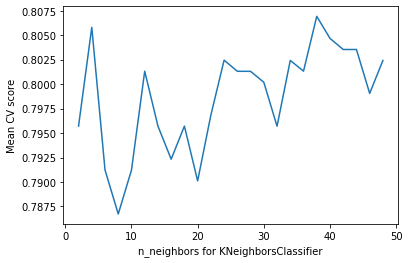

In [60]:
from sklearn.neighbors import KNeighborsClassifier

nn_list = [int(x) for x in np.arange(2,50,2)]
score_list = []
for nn in nn_list:
    model = KNeighborsClassifier(n_neighbors=nn)

    # Pipeline for preprocessing and modeling
    kn_clf = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)
                            ])

    # Apply preprocessing and train model 
    kn_clf.fit(X_clean, y_clean)

    # Cross validation scores for model
    scores = cross_val_score(kn_clf, 
                             X_clean, y_clean, 
                             scoring='accuracy', 
                             cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)) 
    score_list.append(np.mean(scores))
 
# Results of parameter tuning
max_ind = np.where(score_list==max(score_list))[0][0]
print('Best n_neighbors:',np.array(nn_list)[max_ind])

plt.plot(nn_list,score_list)
plt.xlabel('n_neighbors for KNeighborsClassifier')
plt.ylabel('Mean CV score');

In [61]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=38)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
kn_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

# Apply preprocessing and train model 
kn_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(kn_clf, 
                         X_clean, y_clean, 
                         scoring='accuracy', 
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)) 


print("KNeighbors Mean CV score: {} +/- {}".format(np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['KNeighbors', kn_clf.named_steps['model'],
                                         np.round(np.mean(scores),3), np.round(np.std(scores),3),
                                         np.round(accuracy_score(y_clean,kn_clf.predict(X_clean)),3)]


KNeighbors Mean CV score: 0.80694 +/- 0.0347


In [62]:
# Saving KNeighbors predictions on the test data
y_test_kn = kn_clf.predict(X_test_clean)
output = pd.DataFrame({'PassengerId': X_test_clean.index, 
                       'Survived': y_test_kn})
output.to_csv('./output/submission_kn.csv', index=False)

## 6.3 RandomForestClassifier <a id='section_6.3'></a>

In [63]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200,
                               max_features=22,
                               max_depth=3,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=0)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('model', model)
                         ])

# Apply preprocessing and train model 
rf_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(rf_clf, 
                         X_clean, y_clean, 
                         scoring='accuracy', 
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)) 

print("RandomForest Mean CV score: {} +/- {}".format(np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['RandomForestClassifier', rf_clf.named_steps['model'],
                                         np.round(np.mean(scores),3), np.round(np.std(scores),3),
                                         np.round(accuracy_score(y_clean,rf_clf.predict(X_clean)),3)]

RandomForest Mean CV score: 0.83051 +/- 0.0329


In [64]:
rf_clf.named_steps['model'].oob_score_

0.8282828282828283

In [65]:
# Feature names from the preprocessor 
clf_num = rf_clf.named_steps['preprocessor'].transformers_[0][2] 
clf_catnom = rf_clf.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(catnom_cols_final) 

# Creating dataframe of features sorted by importance
rf_fi = pd.concat([pd.Series(list(clf_num)+list(clf_catnom), name='feature'), 
                    pd.Series(rf_clf.named_steps['model'].feature_importances_, name='importance')], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Features selected by RandomForest:', len(np.where(rf_fi['importance']!=0)[0]), '/', len(rf_fi))
print('Fraction of features selected by RandomForest:', np.round(len(np.where(rf_fi['importance']!=0)[0])/len(rf_fi),2))
print('Minimum feature importance:',min(rf_fi['importance'][rf_fi['importance']!=0]))
rf_fi[:5]

Features selected by RandomForest: 39 / 46
Fraction of features selected by RandomForest: 0.85
Minimum feature importance: 2.2216509576160075e-05


,feature,importance
14,Title_Mr.,0.231429
44,Sex_female,0.208170
45,Sex_male,0.197113
2,Pclass,0.091710
6,NCompanions,0.050114


In [66]:
# Saving RandomForest predictions on the test data
y_test_rf = rf_clf.predict(X_test_clean)
output = pd.DataFrame({'PassengerId': X_test_clean.index, 
                       'Survived': y_test_rf})
output.to_csv('./output/submission_rf.csv', index=False)

## 6.4 XGBClassifier <a id='section_6.4'></a>

In [67]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators = 400,
                      learning_rate = 0.1,
                      max_depth = 6,
                      min_child_weight = 10,
                      subsample = 0.8,
                      colsample_bytree = 0.4,
                      random_state=0)


# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

# Apply preprocessing and train model 
xgb_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(xgb_clf, 
                         X_clean, y_clean, 
                         scoring='accuracy', 
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)) 

print("XGBoost Mean CV score: {} +/- {}".format(np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['XGBClassifier', xgb_clf.named_steps['model'],
                                         np.round(np.mean(scores),3), np.round(np.std(scores),3),
                                         np.round(accuracy_score(y_clean,xgb_clf.predict(X_clean)),3)]

XGBoost Mean CV score: 0.82827 +/- 0.0263


In [68]:
# Feature names from the preprocessor 
clf_num = xgb_clf.named_steps['preprocessor'].transformers_[0][2] 
clf_catnom = xgb_clf.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(catnom_cols_final) 

# Creating dataframe of features sorted by importance
xgb_fi = pd.concat([pd.Series(list(clf_num)+list(clf_catnom), name='feature'), 
                    pd.Series(xgb_clf.named_steps['model'].feature_importances_, name='importance')], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Features selected by XGBoost:', len(np.where(xgb_fi['importance']!=0)[0]), '/', len(xgb_fi))
print('Fraction of features selected by XGBoost:', np.round(len(np.where(xgb_fi['importance']!=0)[0])/len(xgb_fi),2))
print('Minimum feature importance:',min(xgb_fi['importance'][xgb_fi['importance']!=0]))
xgb_fi[:5]

Features selected by XGBoost: 22 / 46
Fraction of features selected by XGBoost: 0.48
Minimum feature importance: 0.011237828060984612


,feature,importance
14,Title_Mr.,0.185691
45,Sex_male,0.125599
44,Sex_female,0.118612
42,Embarked_Q,0.081866
25,Deck_None,0.071592


In [69]:
# Saving XGBoost predictions on the test data
y_test_xgb = xgb_clf.predict(X_test_clean)
output = pd.DataFrame({'PassengerId': X_test_clean.index, 
                       'Survived': y_test_xgb})
output.to_csv('./output/submission_xgb.csv', index=False)

## 6.5 SVC <a id='section_6.5'></a>

In [70]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',
            random_state=0)


# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

# Apply preprocessing and train model 
svc_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(svc_clf, 
                         X_clean, y_clean, 
                         scoring='accuracy', 
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)) 


print("SVC Mean CV score: {} +/- {}".format(np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['SVC', svc_clf.named_steps['model'],
                                         np.round(np.mean(scores),3), np.round(np.std(scores),3),
                                         np.round(accuracy_score(y_clean,svc_clf.predict(X_clean)),3)]


SVC Mean CV score: 0.83049 +/- 0.033


In [71]:
# Saving SVC predictions on the test data
y_test_svc = svc_clf.predict(X_test_clean)
output = pd.DataFrame({'PassengerId': X_test_clean.index, 
                       'Survived': y_test_svc})
output.to_csv('./output/submission_svc.csv', index=False)

# 7. Model ensembling and final results <a id='section_7'></a>
[7.1 Comparing model fits](#section_7.1)  
[7.2 Voting ensemble](#section_7.2)  
[7.3 Final predictions from voting ensemble](#section_7.3)  
[7.4 Feature importances](#section_7.4)

##  7.1 Comparing model fits <a id='section_7.1'></a>

In [72]:
models_fit_df

,model,model_clf,mean(CV),stdev(CV),accuracy
0,Ridge,"RidgeClassifier(alpha=14.26, class_weight=None...",0.823,0.030,0.842
1,KNeighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.807,0.035,0.816
2,RandomForestClassifier,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.831,0.033,0.836
3,XGBClassifier,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.828,0.026,0.883
4,SVC,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.830,0.033,0.842


All models perform similarly, except for KNeighbors which returns the lowest accuracy score on the training set. Thus, for my final results I'll take the average of the predictions produced by all models except for KNeighbors, i.e. my final averaged results will be from RidgeClassifier, RandomForestClassifier, XGBClassifier, and SVC.

## 7.2  Voting ensemble  <a id='section_7.2'></a>

In [73]:
from sklearn.ensemble import VotingClassifier

estimators_list = [('Ridge', ridge_clf),('SVC', svc_clf),
                   ('RandomForest', rf_clf),('XGBoost', xgb_clf)]

voting_clf = VotingClassifier(estimators=estimators_list,
                              voting='hard',
                              n_jobs=-1)

voting_clf = voting_clf.fit(X_clean, y_clean)

scores = cross_val_score(voting_clf, 
                         X_clean, y_clean, 
                         scoring='accuracy',
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))

print('Voting ensemble CV scores: {}'.format(scores))
print("Voting ensemble Mean CV score: {}".format(np.mean(scores)))

models_fit_df.loc[len(models_fit_df)] = ['Voting Ensemble', 'avg(Ridge,RF,SVC,XGB)',
                                         np.round(np.mean(scores),3), np.round(np.std(scores),3),
                                         np.round(accuracy_score(y_clean,voting_clf.predict(X_clean)),3)]

Voting ensemble CV scores: [0.8603352  0.87078652 0.83707865 0.78651685 0.80898876]
Voting ensemble Mean CV score: 0.832741196409516


In [74]:
# Saving Ensemble predictions on the test data
y_test_voting = voting_clf.predict(X_test_clean)
output = pd.DataFrame({'PassengerId': X_test_clean.index, 
                       'Survived': y_test_voting})
output.to_csv('./output/submission_voting.csv', index=False)

## 7.3 Final predictions from voting ensemble <a id='section_7.3'></a>

In [75]:
models_fit_df

,model,model_clf,mean(CV),stdev(CV),accuracy
0,Ridge,"RidgeClassifier(alpha=14.26, class_weight=None...",0.823,0.030,0.842
1,KNeighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.807,0.035,0.816
2,RandomForestClassifier,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.831,0.033,0.836
3,XGBClassifier,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.828,0.026,0.883
4,SVC,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.830,0.033,0.842
5,Voting Ensemble,"avg(Ridge,RF,SVC,XGB)",0.833,0.031,0.845


On the training set, the voting ensemble model has a mean cross-validation accuracy of 0.83 +/- 0.03. The predictions from this model on the test data set achieved a score of 0.80382 on the Kaggle leaderboard.

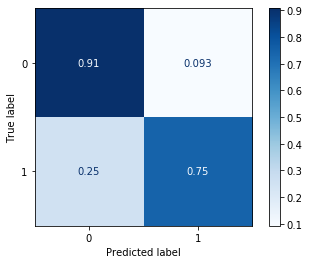

In [76]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(voting_clf, X_clean, y_clean,
                             normalize='true',
                             cmap=plt.cm.Blues)

Investigating the confusion matrix for the training set ensemble predictions, my final model is able to correctly predict 75% of true positives (passengers predicted to survive did survive) and 91% of true negatives (passengers predicted not to survive did not survive). 

The false negative rate: The probability of predicting passengers not surviving when they did survive occurs for 25% of all true positives.

The false positive rate: The probability of predicting passengers would survive when they did not survive occurs for 9.3% of all true negatives.

## 7.4 Feature importances <a id='section_7.4'></a>

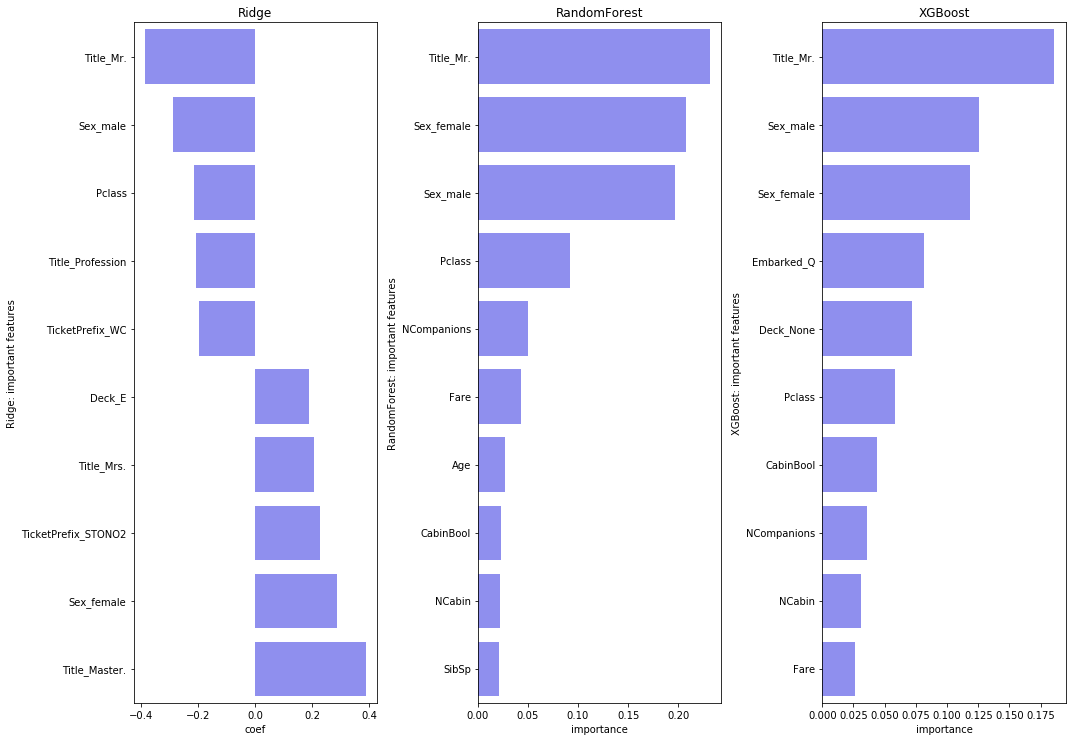

In [77]:
# Plotting feature importances 

fig = plt.figure(figsize=(15, 20)) # (width,height)


'''
Ridge coefficients
'''
ax = plt.subplot(2,3,1)
coef_plt = pd.concat([ridge_coef[:5], ridge_coef[-5:]],axis=0)
sns.barplot(x="coef", y="features", data=coef_plt, color='b', alpha=0.5)
ax.set(ylabel='Ridge: important features')
ax.set_title('Ridge');


'''
RandomForest feature importances
'''
ax = plt.subplot(2,3,2)
rf_fi_plt = rf_fi[:10]
sns.barplot(x="importance", y="feature", data=rf_fi_plt, color='b', alpha=0.5)
ax.set(ylabel='RandomForest: important features')
ax.set_title('RandomForest');


'''
XGBoost feature importances
'''
ax = plt.subplot(2,3,3)
xgb_fi_plt = xgb_fi[:10]
sns.barplot(x="importance", y="feature", data=xgb_fi_plt, color='b', alpha=0.5)
ax.set(ylabel='XGBoost: important features')
ax.set_title('XGBoost');



plt.tight_layout()
#plt.subplots_adjust(wspace=0.5)

Feature importances are available for the RidgeClassifier, RandomForestClassifier, and XGBClassifier models.

Interestingly, a few of the specific ticket prefixes appeared as significant features in the RidgeClassifier model, but were not very important for the tree-based models.

The most important features for all three models are: 'Title', 'Sex', and 'Pclass'.

# Useful References
Some resources I found to be especially helpful in preparation of working on this project:

- "Introduction to Machine Learning with Python: A Guide for Data Scientists" - Andreas C. Müller and Sarah Guido
- [Kaggle Tutorials](https://www.kaggle.com/learn/overview)
- ["Predicting the Survival of Titanic Passengers"](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)

